ref:
https://nbviewer.jupyter.org/github/blei-lab/edward/blob/master/notebooks/getting_started.ipynb

http://edwardlib.org/getting-started

****** for notation
http://edwardlib.org/api/inference

 Here we will show a Bayesian neural network. It is a neural network with a prior distribution on its weights.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
from edward.models import Normal

plt.style.use('ggplot')

/Users/sharmila/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/sharmila/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/sharmila/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/sharmila/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [2]:
# Getting needed data

data = np.loadtxt('motor.dat')

X_data = data[:, 0][:, None]
y_data = data[:, 1]

print (np.shape(X_data),np.shape(y_data))

X_data = np.float32(X_data)
y_data = np.float32(y_data)

(94, 1) (94,)


In [3]:
# Shuffling dataset
from sklearn.utils import shuffle

X_data_shuff,y_data_shuff = shuffle(X_data,y_data,random_state=23)
print (np.shape(X_data_shuff),np.shape(y_data_shuff))

(94, 1) (94,)


In [4]:
# Splitting dataset

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data_shuff, y_data_shuff, test_size=0.2, random_state=23)
print (np.shape(X_train), np.shape(y_train))
print (np.shape(X_test), np.shape(y_test))

(75, 1) (75,)
(19, 1) (19,)


In [5]:
D = np.shape(X_train)[1]  # number of features or number of input neurons
H = 25
print (D,H) 

1 25


In [6]:
ed.set_seed(42)

Next, define a two-layer Bayesian neural network. Here, we define the neural network manually with `tanh` nonlinearities.

In [7]:
# Neural network number of neurons [D,H,H,1]
def neural_network(x, W_0, W_1, W_2, b_0, b_1, b_2):
    h = tf.tanh(tf.matmul(x, W_0) + b_0)
    h = tf.tanh(tf.matmul(h, W_1) + b_1)
    h = tf.matmul(h, W_2) + b_2
    return tf.reshape(h, [-1])

# prior
W_0 = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]),name="W_0")
W_1 = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]), name="W_1")
W_2 = Normal(loc=tf.zeros([H, 1]), scale=tf.ones([H, 1]), name="W_2")
b_0 = Normal(loc=tf.zeros(H), scale=tf.ones(H), name="b_0")
b_1 = Normal(loc=tf.zeros(H), scale=tf.ones(H), name="b_1")
b_2 = Normal(loc=tf.zeros(1), scale=tf.ones(1), name="b_2")

#likelihood
X = tf.placeholder(tf.float32, [None, D], name="X")
y = Normal(loc=neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2),
           scale=0.1 , name="y")

Next, make inferences about the model from data. We will use variational inference. Specify a normal approximation over the weights and biases.

q's are random variables defined to approximate the posterior [http://edwardlib.org/api/inference]

In [8]:
qW_0 = Normal(loc=tf.get_variable("qW_0/loc", [D, H]),
              scale=tf.nn.softplus(tf.get_variable("qW_0/scale", [D, H])))
qW_1 = Normal(loc=tf.get_variable("qW_1/loc", [H, H]),
              scale=tf.nn.softplus(tf.get_variable("qW_1/scale", [H, H])))
qW_2 = Normal(loc=tf.get_variable("qW_2/loc", [H, 1]),
              scale=tf.nn.softplus(tf.get_variable("qW_2/scale", [H, 1])))
qb_0 = Normal(loc=tf.get_variable("qb_0/loc", [H]),
              scale=tf.nn.softplus(tf.get_variable("qb_0/scale", [H])))
qb_1 = Normal(loc=tf.get_variable("qb_1/loc", [H]),
              scale=tf.nn.softplus(tf.get_variable("qb_1/scale", [H])))
qb_2 = Normal(loc=tf.get_variable("qb_2/loc", [1]),
              scale=tf.nn.softplus(tf.get_variable("qb_2/scale", [1])))

Defining `tf.get_variable` allows the variational factors’ parameters to vary. They are initialized randomly. The standard deviation parameters are constrained to be greater than zero according to a [softplus](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) transformation.

In [9]:
# Sample functions from variational model to visualize fits.
qW_0_s = qW_0.sample(1000)
qW_1_s = qW_1.sample(1000)
qW_2_s = qW_2.sample(1000)
qb_0_s = qb_0.sample(1000)
qb_1_s = qb_1.sample(1000)
qb_2_s = qb_2.sample(1000)
preds = tf.stack(
    [neural_network(X_data, qW_0_s[i], qW_1_s[i], qW_2_s[i],
                    qb_0_s[i], qb_1_s[i], qb_2_s[i])
     for i in range(1000)])

(1000, 94)
(94,)
(999, 94)


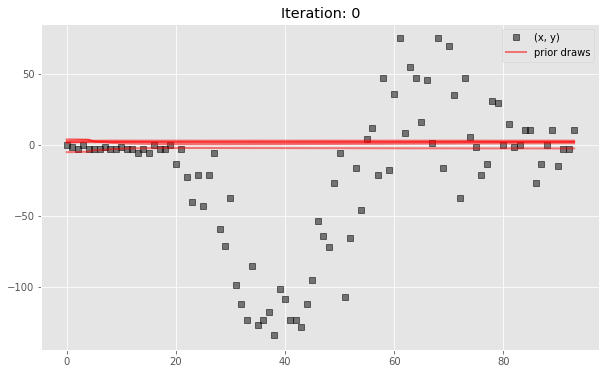

In [10]:
# FIRST VISUALIZATION (prior) #before optimization

sess = ed.get_session()
tf.global_variables_initializer().run()
outputs = preds.eval()

print(np.shape(outputs))
print(np.shape(outputs[0]))
print(np.shape(outputs[1:]))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 0")
ax.plot( y_data, 'ks', alpha=0.5, label='(x, y)') # full data (train+test)
ax.plot(outputs[0].T, 'r', lw=2, alpha=0.5, label='prior draws')
ax.plot(outputs[1:5].T, 'r', lw=2, alpha=0.5)
ax.legend()
plt.show()

Now, run variational inference with the [Kullback-Leibler](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence) divergence in order to infer the model’s latent variables given data. We specify `1000` iterations.

/Users/sharmila/anaconda3/envs/py36/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


5000/5000 [100%] ██████████████████████████████ Elapsed: 15s | Loss: 1688343.125


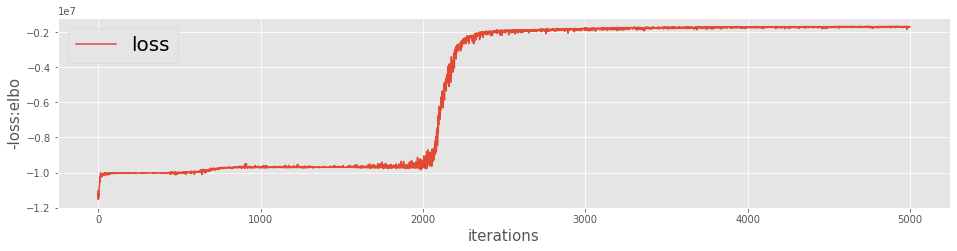

In [11]:
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1,
                     W_2: qW_2, b_2: qb_2}, data={X:X_train,y: y_train})

# inference.run(n_iter=1000, n_samples=5)

#or

#reference:
# http://edwardlib.org/tutorials/mixture-density-network
# http://edwardlib.org/api/inference
inference.initialize(n_iter=5000, n_samples=5)
LOSS = np.zeros(inference.n_iter)
tf.global_variables_initializer().run()
for i in range(inference.n_iter):
    info_dict = inference.update()
    LOSS[i] = info_dict['loss']
    inference.print_progress(info_dict)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(inference.n_iter), -LOSS, label='loss')
plt.legend(fontsize=20)
plt.xlabel('iterations', fontsize=15)
plt.ylabel('-loss:elbo', fontsize=15)
plt.show()    


In [12]:
# print(help(inference))

Finally, criticize the model fit. Bayesian neural networks define a distribution over neural networks, so we can perform a graphical check. Draw neural networks from the inferred model and visualize how well it fits the data.

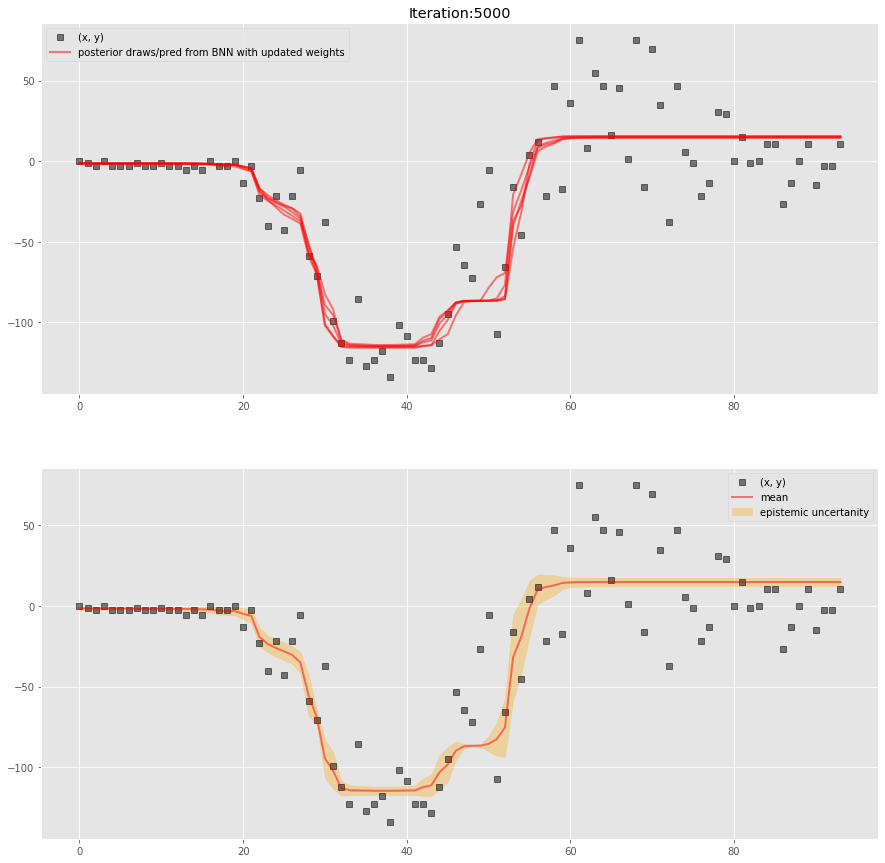

In [13]:
# SECOND VISUALIZATION (posterior) #after optimization

outputs = preds.eval()

fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(211)
ax1.set_title("Iteration:"+str(inference.n_iter))
ax1.plot( y_data, 'ks', alpha=0.5, label='(x, y)') # full data (train+test)
ax1.plot( outputs[0].T, 'r', lw=2, alpha=0.5, label='posterior draws/pred from BNN with updated weights')
ax1.plot( outputs[1:5].T, 'r', lw=2, alpha=0.5)
ax1.legend()


mean_pred = np.mean(outputs, axis=0)
std_pred = np.std(outputs, axis=0)
ax2 = fig.add_subplot(212)
ax2.plot( y_data, 'ks', alpha=0.5, label='(x, y)') # full data (train+test)
ax2.plot(  mean_pred , 'r', lw=2, alpha=0.5, label='mean')
ax2.fill_between( np.arange(len(y_data)), mean_pred-2*std_pred, mean_pred+2*std_pred, alpha = 0.3, color = 'orange',label='epistemic uncertanity')
ax2.legend()

plt.show()

The model has captured the relationship between $x$ and $y$ in the observed domain.

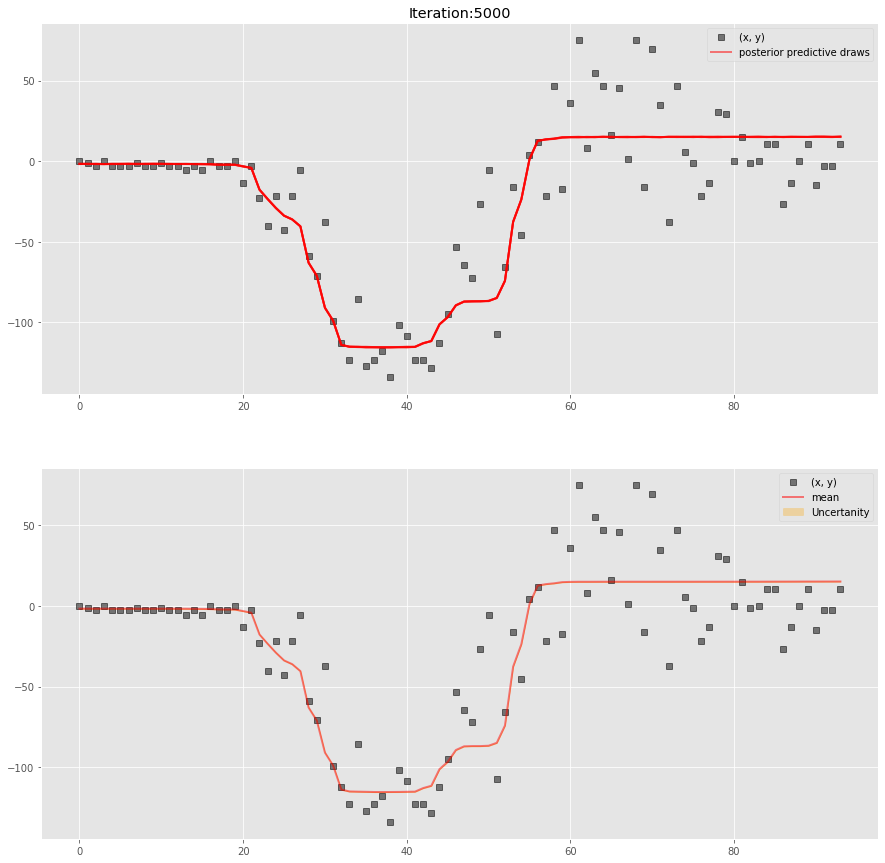

In [14]:
# THIRD VISUALIZATION (posterior predictive) 

# preds_lik = tf.stack(
#     [ Normal( loc=neural_network(X_data, qW_0_s[i], qW_1_s[i], qW_2_s[i],
#                     qb_0_s[i], qb_1_s[i], qb_2_s[i]),scale=0.1 ).sample() 
#      for i in range(1000)])
# outputs_lik = preds_lik.eval()

# or 
# (ref:http://edwardlib.org/tutorials/batch-training)
y_post = ed.copy(y, {W_0: qW_0, W_1: qW_1, W_2: qW_2, b_0: qb_0, b_1: qb_1, b_2: qb_2})
# This is equivalent to
# y_post = Normal( loc=neural_network(X, qW_0, qW_1, qW_2,
#                     qb_0, qb_1, qb_2),scale=0.1 )
preds_lik = tf.stack(
    [ y_post.sample() 
     for _ in range(1000)])
outputs_lik = preds_lik.eval(feed_dict={X:X_data})


fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(211)
ax1.set_title("Iteration:"+str(inference.n_iter))
ax1.plot(y_data, 'ks', alpha=0.5, label='(x, y)') # full data (train+test)
ax1.plot( outputs_lik[0].T, 'r', lw=2, alpha=0.5, label='posterior predictive draws')
ax1.plot( outputs_lik[1:5].T, 'r', lw=2, alpha=0.5)
ax1.legend()

mean_pred_lik = np.mean(outputs_lik, axis=0)
std_pred_lik = np.std(outputs_lik, axis=0)
ax2 = fig.add_subplot(212)
ax2.plot( y_data, 'ks', alpha=0.5, label='(x, y)') # full data (train+test)
ax2.plot(  mean_pred_lik , 'r', lw=2, alpha=0.5, label='mean')
ax2.fill_between( np.arange(len(y_data)), mean_pred_lik-2*std_pred_lik, mean_pred_lik+2*std_pred_lik, alpha = 0.3, color = 'orange',label='Uncertanity')
ax2.legend()

plt.show()

         KLqp  actual  error_KLqp
0   -1.712526     0.0   -1.712526
1   -1.706772    -1.3   -0.406772
2   -1.707136    -2.7    0.992864
3   -1.711299     0.0   -1.711299
4   -1.719485    -2.7    0.980515
..        ...     ...         ...
89  15.111995    10.7    4.411995
90  15.112575   -14.7   29.812574
91  15.127728    -2.7   17.827728
92  15.129009    -2.7   17.829010
93  15.146622    10.7    4.446622

[94 rows x 3 columns]
RMSE for KLqp predictions = 23.504


/Users/sharmila/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


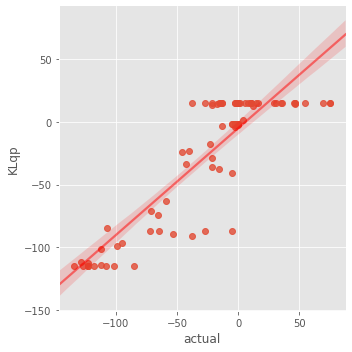

In [15]:
prediction_data = pd.DataFrame(
    {'KLqp': mean_pred_lik.flatten(), 
     'actual': y_data.flatten(),
     'error_KLqp': ( mean_pred_lik - y_data).flatten()})

print (prediction_data)

_ = sns.lmplot(y='KLqp', x='actual', data=prediction_data,
               line_kws={'color': 'red', 'alpha': 0.5})

RMSE = np.sqrt(np.mean(prediction_data.error_KLqp ** 2))
print(f'RMSE for KLqp predictions = {RMSE:.3f}')

In [16]:
# print (y_post)
# print(W_0)

In [17]:
# https://nbviewer.jupyter.org/github/blei-lab/edward/blob/master/notebooks/batch_training.ipynb
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}, n_samples=500))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={X: X_test, y_post: y_test}, n_samples=500))

Mean squared error on test data:
992.97864
Mean absolute error on test data:
22.28393


(1000, 1, 25)


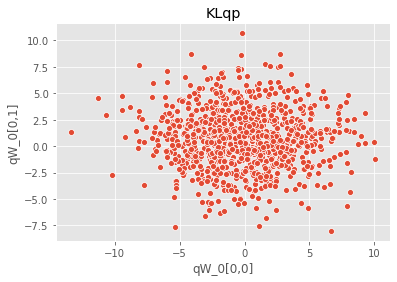

In [18]:
check = qW_0.sample(1000).eval()
print(check.shape)
param_samples_KLqp = pd.DataFrame(
    {'qW_0[0,0]': check.reshape(check.shape[0],check.shape[2])[:,0], 
     'qW_0[0,1]': check.reshape(check.shape[0],check.shape[2])[:,1]})

_ = sns.scatterplot(x='qW_0[0,0]', y='qW_0[0,1]', data=param_samples_KLqp).set_title('KLqp')

In [19]:
print(qW_0.loc,qW_0.loc.eval())
print(qW_0.scale,qW_0.scale.eval())

Tensor("Normal/loc:0", shape=(1, 25), dtype=float32) [[-0.18166478  0.4949015  -0.9827671  -1.3323673   0.7396168  -1.9857161
  -1.7235662  -1.5765009   0.57345676 -0.30367264  0.6280731   0.83127594
   0.7262344   0.33845946  1.5499626   2.1495295  -1.1759639  -1.3449417
   2.5701861  -1.5895344   1.5860344   0.9835088  -1.5595376   1.7919034
   0.6383669 ]]
Tensor("Normal/scale:0", shape=(1, 25), dtype=float32) [[3.5460033e+00 2.7332263e+00 2.4881755e-01 3.4078181e-01 1.1210117e-03
  3.4317607e-01 2.7263501e-01 3.4988278e-01 1.7250194e-03 1.6531465e+00
  4.3694992e+00 1.7034562e-01 2.6030955e+00 5.6140620e-01 3.5482842e-01
  6.1103123e-01 2.3996167e-01 2.3309939e-01 8.2183242e-01 4.0177083e-01
  3.8378364e-01 4.3469932e-02 3.9803913e-01 3.7386897e-01 2.6200533e+00]]


In [20]:
print(W_0.loc,W_0.loc.eval())
print(W_0.scale,W_0.scale.eval())

Tensor("W_0/loc:0", shape=(1, 25), dtype=float32) [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]]
Tensor("W_0/scale:0", shape=(1, 25), dtype=float32) [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1.]]
